In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

from utils import seed
from data import dataset
from model.backbone import VGG16, ResNet34
from model import basic_classifier
from utils import train

seed.seed_everything()

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# VGG

In [3]:
# (already downloaded) dataset path 
path = './data'

train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=96,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=256,
                                                          seed=21)

In [4]:
backbone = VGG16.VGG16_Backbone(pretrain=True).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

print(model)

BasicClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [5]:
EPOCHS = 50

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
es = train.EarlyStopping(patience=EPOCHS//2, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//5, gamma=0.9)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf    

In [6]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=scheduler, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_loss)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model_VGG_1.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:07<00:00,  1.87it/s]


[EarlyStopping] (Update) Best Score: 0.43492
[INFO] val_loss has been improved from inf to 0.43492. Save model.
epoch 01, loss: 0.41964, accuracy: 0.80840, val_loss: 0.43492, val_accuracy: 0.78830 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Update) Best Score: 0.43046
[INFO] val_loss has been improved from 0.43492 to 0.43046. Save model.
epoch 02, loss: 0.39392, accuracy: 0.82237, val_loss: 0.43046, val_accuracy: 0.79050 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:06<00:00,  1.87it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.43046, Current: 0.43797, Delta: 0.00751
epoch 03, loss: 0.38826, accuracy: 0.82529, val_loss: 0.43797, val_accuracy: 0.79388 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.42292
[INFO] val_loss has been improved from 0.43046 to 0.42292. Save model.
epoch 04, loss: 0.38531, accuracy: 0.82659, val_loss: 0.42292, val_accuracy: 0.79407 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.42292, Current: 0.42902, Delta: 0.00610
epoch 05, loss: 0.38549, accuracy: 0.82757, val_loss: 0.42902, val_accuracy: 0.79407 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.42292, Current: 0.42937, Delta: 0.00645
epoch 06, loss: 0.38250, accuracy: 0.82898, val_loss: 0.42937, val_accuracy: 0.79254 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.42292, Current: 0.42552, Delta: 0.00260
epoch 07, loss: 0.38193, accuracy: 0.82906, val_loss: 0.42552, val_accuracy: 0.79675 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Update) Best Score: 0.42134
[INFO] val_loss has been improved from 0.42292 to 0.42134. Save model.
epoch 08, loss: 0.38150, accuracy: 0.82930, val_loss: 0.42134, val_accuracy: 0.79703 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.42134, Current: 0.43093, Delta: 0.00959
epoch 09, loss: 0.38069, accuracy: 0.82976, val_loss: 0.43093, val_accuracy: 0.78967 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.41808
[INFO] val_loss has been improved from 0.42134 to 0.41808. Save model.
epoch 10, loss: 0.38032, accuracy: 0.82973, val_loss: 0.41808, val_accuracy: 0.79602 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.41808, Current: 0.41945, Delta: 0.00137
epoch 11, loss: 0.37823, accuracy: 0.83176, val_loss: 0.41945, val_accuracy: 0.79675 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.41808, Current: 0.43025, Delta: 0.01217
epoch 12, loss: 0.37700, accuracy: 0.83241, val_loss: 0.43025, val_accuracy: 0.78918 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.41808, Current: 0.43847, Delta: 0.02038
epoch 13, loss: 0.37818, accuracy: 0.83167, val_loss: 0.43847, val_accuracy: 0.78305 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.41808, Current: 0.42467, Delta: 0.00658
epoch 14, loss: 0.37692, accuracy: 0.83193, val_loss: 0.42467, val_accuracy: 0.79266 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.41808, Current: 0.42270, Delta: 0.00462
epoch 15, loss: 0.37706, accuracy: 0.83173, val_loss: 0.42270, val_accuracy: 0.79678 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:07<00:00,  1.87it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.41808, Current: 0.42947, Delta: 0.01139
epoch 16, loss: 0.37777, accuracy: 0.83191, val_loss: 0.42947, val_accuracy: 0.79468 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.41662
[INFO] val_loss has been improved from 0.41808 to 0.41662. Save model.
epoch 17, loss: 0.37721, accuracy: 0.83258, val_loss: 0.41662, val_accuracy: 0.79651 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.41662, Current: 0.44426, Delta: 0.02764
epoch 18, loss: 0.37742, accuracy: 0.83202, val_loss: 0.44426, val_accuracy: 0.78149 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.41662, Current: 0.41876, Delta: 0.00214
epoch 19, loss: 0.37723, accuracy: 0.83209, val_loss: 0.41876, val_accuracy: 0.79950 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.41662, Current: 0.44639, Delta: 0.02976
epoch 20, loss: 0.37650, accuracy: 0.83231, val_loss: 0.44639, val_accuracy: 0.78442 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:14<00:00,  1.85it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.41662, Current: 0.41975, Delta: 0.00312
epoch 21, loss: 0.37433, accuracy: 0.83361, val_loss: 0.41975, val_accuracy: 0.79745 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.40728
[INFO] val_loss has been improved from 0.41662 to 0.40728. Save model.
epoch 22, loss: 0.37425, accuracy: 0.83383, val_loss: 0.40728, val_accuracy: 0.80328 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.40728, Current: 0.44430, Delta: 0.03701
epoch 23, loss: 0.37603, accuracy: 0.83258, val_loss: 0.44430, val_accuracy: 0.78659 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.40728, Current: 0.41652, Delta: 0.00924
epoch 24, loss: 0.37431, accuracy: 0.83296, val_loss: 0.41652, val_accuracy: 0.80023 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.40728, Current: 0.43082, Delta: 0.02354
epoch 25, loss: 0.37430, accuracy: 0.83352, val_loss: 0.43082, val_accuracy: 0.79214 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.40728, Current: 0.44360, Delta: 0.03632
epoch 26, loss: 0.37372, accuracy: 0.83369, val_loss: 0.44360, val_accuracy: 0.78854 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.40728, Current: 0.42401, Delta: 0.01673
epoch 27, loss: 0.37407, accuracy: 0.83351, val_loss: 0.42401, val_accuracy: 0.80286 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.40728, Current: 0.44558, Delta: 0.03830
epoch 28, loss: 0.37551, accuracy: 0.83250, val_loss: 0.44558, val_accuracy: 0.79092 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 7/25, Best: 0.40728, Current: 0.42536, Delta: 0.01808
epoch 29, loss: 0.37415, accuracy: 0.83394, val_loss: 0.42536, val_accuracy: 0.79706 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 8/25, Best: 0.40728, Current: 0.42071, Delta: 0.01343
epoch 30, loss: 0.37350, accuracy: 0.83381, val_loss: 0.42071, val_accuracy: 0.80154 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 9/25, Best: 0.40728, Current: 0.41865, Delta: 0.01137
epoch 31, loss: 0.37265, accuracy: 0.83458, val_loss: 0.41865, val_accuracy: 0.79861 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.87it/s]


[EarlyStopping] (Patience) 10/25, Best: 0.40728, Current: 0.42020, Delta: 0.01292
epoch 32, loss: 0.37261, accuracy: 0.83511, val_loss: 0.42020, val_accuracy: 0.79990 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 11/25, Best: 0.40728, Current: 0.44010, Delta: 0.03282
epoch 33, loss: 0.37130, accuracy: 0.83541, val_loss: 0.44010, val_accuracy: 0.78979 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 12/25, Best: 0.40728, Current: 0.42290, Delta: 0.01562
epoch 34, loss: 0.37313, accuracy: 0.83403, val_loss: 0.42290, val_accuracy: 0.79620 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 13/25, Best: 0.40728, Current: 0.41162, Delta: 0.00434
epoch 35, loss: 0.37324, accuracy: 0.83369, val_loss: 0.41162, val_accuracy: 0.80481 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 14/25, Best: 0.40728, Current: 0.42295, Delta: 0.01567
epoch 36, loss: 0.37141, accuracy: 0.83510, val_loss: 0.42295, val_accuracy: 0.79819 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.86it/s]


[EarlyStopping] (Patience) 15/25, Best: 0.40728, Current: 0.41060, Delta: 0.00332
epoch 37, loss: 0.37171, accuracy: 0.83509, val_loss: 0.41060, val_accuracy: 0.80243 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 16/25, Best: 0.40728, Current: 0.42802, Delta: 0.02074
epoch 38, loss: 0.37367, accuracy: 0.83429, val_loss: 0.42802, val_accuracy: 0.79984 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 17/25, Best: 0.40728, Current: 0.41637, Delta: 0.00909
epoch 39, loss: 0.37268, accuracy: 0.83508, val_loss: 0.41637, val_accuracy: 0.80191 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Patience) 18/25, Best: 0.40728, Current: 0.42445, Delta: 0.01717
epoch 40, loss: 0.37164, accuracy: 0.83527, val_loss: 0.42445, val_accuracy: 0.79950 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 19/25, Best: 0.40728, Current: 0.42550, Delta: 0.01822
epoch 41, loss: 0.37116, accuracy: 0.83551, val_loss: 0.42550, val_accuracy: 0.79706 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 20/25, Best: 0.40728, Current: 0.41120, Delta: 0.00392
epoch 42, loss: 0.37078, accuracy: 0.83557, val_loss: 0.41120, val_accuracy: 0.80371 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 21/25, Best: 0.40728, Current: 0.42476, Delta: 0.01748
epoch 43, loss: 0.36975, accuracy: 0.83588, val_loss: 0.42476, val_accuracy: 0.79169 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.39947
[INFO] val_loss has been improved from 0.40728 to 0.39947. Save model.
epoch 44, loss: 0.36992, accuracy: 0.83568, val_loss: 0.39947, val_accuracy: 0.80856 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.39947, Current: 0.41699, Delta: 0.01752
epoch 45, loss: 0.37151, accuracy: 0.83525, val_loss: 0.41699, val_accuracy: 0.80118 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.39947, Current: 0.41396, Delta: 0.01449
epoch 46, loss: 0.37115, accuracy: 0.83566, val_loss: 0.41396, val_accuracy: 0.80048 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.39947, Current: 0.41579, Delta: 0.01632
epoch 47, loss: 0.37079, accuracy: 0.83628, val_loss: 0.41579, val_accuracy: 0.80283 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.39947, Current: 0.42486, Delta: 0.02538
epoch 48, loss: 0.37116, accuracy: 0.83600, val_loss: 0.42486, val_accuracy: 0.79739 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.39947, Current: 0.43648, Delta: 0.03700
epoch 49, loss: 0.37094, accuracy: 0.83535, val_loss: 0.43648, val_accuracy: 0.78949 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.39947, Current: 0.41240, Delta: 0.01292
epoch 50, loss: 0.36999, accuracy: 0.83643, val_loss: 0.41240, val_accuracy: 0.79932 



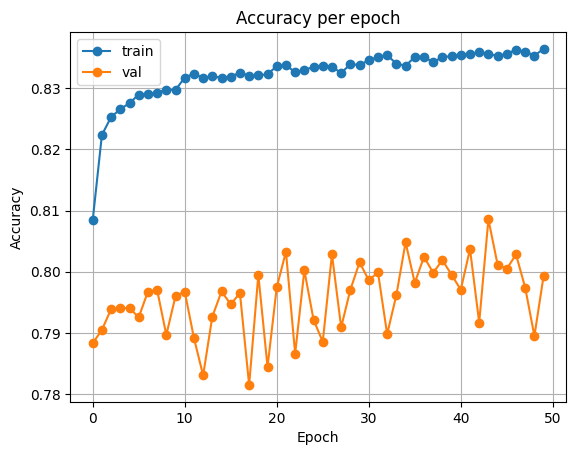

In [7]:
train.plot_acc(history=history)

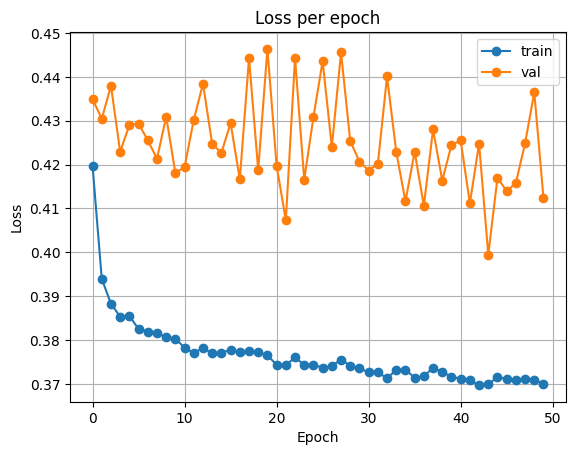

In [8]:
train.plot_loss(history=history)

In [9]:
backbone = VGG16.VGG16_Backbone(pretrain=False).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

model.load_state_dict(torch.load('Best_Model_VGG_1.pth', map_location=device))
model.eval()

test_loss, test_acc = train.model_evaluate(model=model,
                                           data_loader=test_loader,
                                           criterion=criterion,
                                           device=device)

print('Test Loss: %s'%test_loss)
print('Test Accuracy: %s'%test_acc)

Test Loss: 0.46649042423814535
Test Accuracy: 0.777862548828125


# ResNet

In [4]:
train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=96,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=256,
                                                          seed=21)

In [5]:
backbone = ResNet34.ResNet34_Backbone(pretrain=True).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

print(model)

BasicClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [6]:
EPOCHS = 50

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
es = train.EarlyStopping(patience=EPOCHS//2, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//5, gamma=0.9)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf    

In [7]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=scheduler, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_loss)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model_ResNet_1.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Update) Best Score: 0.41722
[INFO] val_loss has been improved from inf to 0.41722. Save model.
epoch 01, loss: 0.42279, accuracy: 0.80595, val_loss: 0.41722, val_accuracy: 0.79977 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Update) Best Score: 0.40410
[INFO] val_loss has been improved from 0.41722 to 0.40410. Save model.
epoch 02, loss: 0.39465, accuracy: 0.82263, val_loss: 0.40410, val_accuracy: 0.80759 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.40410, Current: 0.40724, Delta: 0.00314
epoch 03, loss: 0.38974, accuracy: 0.82631, val_loss: 0.40724, val_accuracy: 0.80386 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:53<00:00,  2.16it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.40410, Current: 0.40563, Delta: 0.00153
epoch 04, loss: 0.38514, accuracy: 0.82820, val_loss: 0.40563, val_accuracy: 0.80920 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Update) Best Score: 0.38755
[INFO] val_loss has been improved from 0.40410 to 0.38755. Save model.
epoch 05, loss: 0.38500, accuracy: 0.82854, val_loss: 0.38755, val_accuracy: 0.81607 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.38755, Current: 0.40213, Delta: 0.01458
epoch 06, loss: 0.38230, accuracy: 0.82991, val_loss: 0.40213, val_accuracy: 0.80664 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.38755, Current: 0.40601, Delta: 0.01846
epoch 07, loss: 0.38269, accuracy: 0.82992, val_loss: 0.40601, val_accuracy: 0.80295 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.38755, Current: 0.40217, Delta: 0.01462
epoch 08, loss: 0.38207, accuracy: 0.83060, val_loss: 0.40217, val_accuracy: 0.80859 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:53<00:00,  2.16it/s]


[EarlyStopping] (Update) Best Score: 0.38522
[INFO] val_loss has been improved from 0.38755 to 0.38522. Save model.
epoch 09, loss: 0.38093, accuracy: 0.83153, val_loss: 0.38522, val_accuracy: 0.81879 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Update) Best Score: 0.38465
[INFO] val_loss has been improved from 0.38522 to 0.38465. Save model.
epoch 10, loss: 0.38223, accuracy: 0.83081, val_loss: 0.38465, val_accuracy: 0.82211 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.38465, Current: 0.39339, Delta: 0.00873
epoch 11, loss: 0.37774, accuracy: 0.83241, val_loss: 0.39339, val_accuracy: 0.81018 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Update) Best Score: 0.37997
[INFO] val_loss has been improved from 0.38465 to 0.37997. Save model.
epoch 12, loss: 0.38031, accuracy: 0.83140, val_loss: 0.37997, val_accuracy: 0.82150 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.37997, Current: 0.39092, Delta: 0.01095
epoch 13, loss: 0.37891, accuracy: 0.83213, val_loss: 0.39092, val_accuracy: 0.81757 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.37997, Current: 0.38929, Delta: 0.00933
epoch 14, loss: 0.37937, accuracy: 0.83205, val_loss: 0.38929, val_accuracy: 0.81686 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.16it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.37997, Current: 0.39197, Delta: 0.01200
epoch 15, loss: 0.37860, accuracy: 0.83225, val_loss: 0.39197, val_accuracy: 0.81418 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.37997, Current: 0.39456, Delta: 0.01460
epoch 16, loss: 0.37813, accuracy: 0.83167, val_loss: 0.39456, val_accuracy: 0.81516 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.37997, Current: 0.39595, Delta: 0.01598
epoch 17, loss: 0.37841, accuracy: 0.83268, val_loss: 0.39595, val_accuracy: 0.81476 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.16it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.37997, Current: 0.41231, Delta: 0.03234
epoch 18, loss: 0.37760, accuracy: 0.83240, val_loss: 0.41231, val_accuracy: 0.79752 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Patience) 7/25, Best: 0.37997, Current: 0.39868, Delta: 0.01872
epoch 19, loss: 0.37866, accuracy: 0.83224, val_loss: 0.39868, val_accuracy: 0.80859 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 8/25, Best: 0.37997, Current: 0.39637, Delta: 0.01641
epoch 20, loss: 0.37893, accuracy: 0.83343, val_loss: 0.39637, val_accuracy: 0.81238 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 9/25, Best: 0.37997, Current: 0.38647, Delta: 0.00650
epoch 21, loss: 0.37784, accuracy: 0.83294, val_loss: 0.38647, val_accuracy: 0.81717 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.14it/s]


[EarlyStopping] (Patience) 10/25, Best: 0.37997, Current: 0.39446, Delta: 0.01449
epoch 22, loss: 0.37687, accuracy: 0.83341, val_loss: 0.39446, val_accuracy: 0.81671 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Patience) 11/25, Best: 0.37997, Current: 0.39089, Delta: 0.01093
epoch 23, loss: 0.37658, accuracy: 0.83373, val_loss: 0.39089, val_accuracy: 0.81592 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:52<00:00,  2.16it/s]


[EarlyStopping] (Patience) 12/25, Best: 0.37997, Current: 0.38891, Delta: 0.00894
epoch 24, loss: 0.37708, accuracy: 0.83316, val_loss: 0.38891, val_accuracy: 0.81689 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 13/25, Best: 0.37997, Current: 0.39479, Delta: 0.01482
epoch 25, loss: 0.37699, accuracy: 0.83257, val_loss: 0.39479, val_accuracy: 0.81042 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 14/25, Best: 0.37997, Current: 0.39108, Delta: 0.01111
epoch 26, loss: 0.37738, accuracy: 0.83324, val_loss: 0.39108, val_accuracy: 0.81390 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 15/25, Best: 0.37997, Current: 0.38658, Delta: 0.00662
epoch 27, loss: 0.37742, accuracy: 0.83380, val_loss: 0.38658, val_accuracy: 0.81662 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 16/25, Best: 0.37997, Current: 0.38950, Delta: 0.00953
epoch 28, loss: 0.37793, accuracy: 0.83321, val_loss: 0.38950, val_accuracy: 0.81223 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 17/25, Best: 0.37997, Current: 0.38531, Delta: 0.00535
epoch 29, loss: 0.37565, accuracy: 0.83381, val_loss: 0.38531, val_accuracy: 0.81815 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.15it/s]


[EarlyStopping] (Patience) 18/25, Best: 0.37997, Current: 0.39570, Delta: 0.01574
epoch 30, loss: 0.37705, accuracy: 0.83393, val_loss: 0.39570, val_accuracy: 0.81311 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 19/25, Best: 0.37997, Current: 0.38492, Delta: 0.00496
epoch 31, loss: 0.37535, accuracy: 0.83518, val_loss: 0.38492, val_accuracy: 0.81848 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 20/25, Best: 0.37997, Current: 0.38392, Delta: 0.00396
epoch 32, loss: 0.37575, accuracy: 0.83402, val_loss: 0.38392, val_accuracy: 0.81625 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:55<00:00,  2.16it/s]


[EarlyStopping] (Patience) 21/25, Best: 0.37997, Current: 0.38686, Delta: 0.00689
epoch 33, loss: 0.37482, accuracy: 0.83524, val_loss: 0.38686, val_accuracy: 0.81833 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 22/25, Best: 0.37997, Current: 0.39354, Delta: 0.01358
epoch 34, loss: 0.37573, accuracy: 0.83370, val_loss: 0.39354, val_accuracy: 0.81192 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:54<00:00,  2.16it/s]


[EarlyStopping] (Patience) 23/25, Best: 0.37997, Current: 0.38373, Delta: 0.00377
epoch 35, loss: 0.37547, accuracy: 0.83378, val_loss: 0.38373, val_accuracy: 0.81955 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:53<00:00,  2.16it/s]


[EarlyStopping] (Patience) 24/25, Best: 0.37997, Current: 0.39995, Delta: 0.01999
epoch 36, loss: 0.37451, accuracy: 0.83488, val_loss: 0.39995, val_accuracy: 0.81302 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 25/25, Best: 0.37997, Current: 0.39031, Delta: 0.01034
[EarlyStop Triggered] Best Score: 0.37997


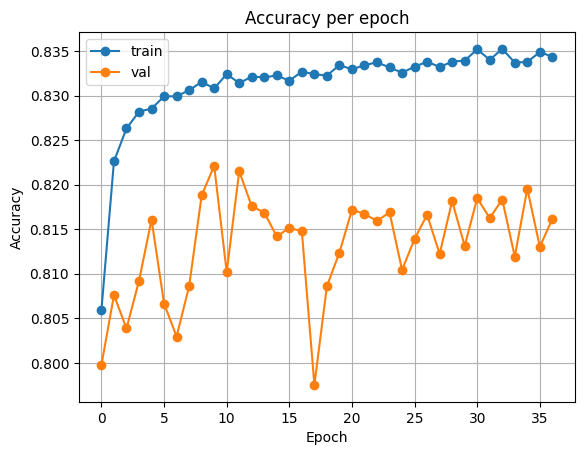

In [8]:
train.plot_acc(history=history)

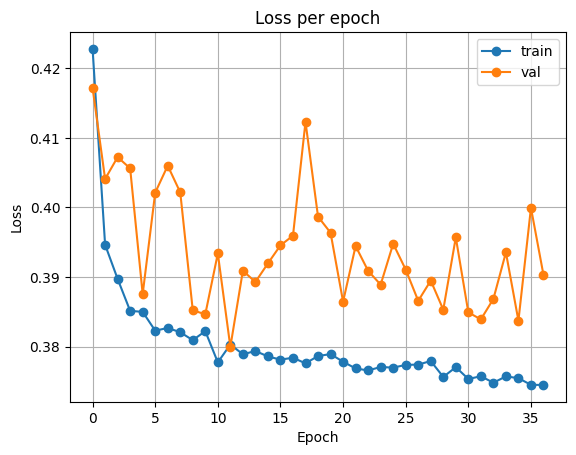

In [9]:
train.plot_loss(history=history)

In [10]:
backbone = ResNet34.ResNet34_Backbone(pretrain=False).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

model.load_state_dict(torch.load('Best_Model_ResNet_1.pth', map_location=device))
model.eval()

test_loss, test_acc = train.model_evaluate(model=model,
                                           data_loader=test_loader,
                                           criterion=criterion,
                                           device=device)

print('Test Loss: %s'%test_loss)
print('Test Accuracy: %s'%test_acc)

Test Loss: 0.4385412798728794
Test Accuracy: 0.789031982421875
